In [1]:
from math import log
from os.path import basename, join
from scipy.stats import pearsonr

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import string

## How to use this notebook

**Input**: MAG summary statistics table(s) `uhgg.summary.csv` generated by the script `summarize_reports.py`. 

**Output**: 

1) Grouped bar graph(s) of the number of contigs, bases, and mean contig length made be each *de novo* assembler grouped by sample. 

2) Violin plots of all contigs lengths for each *de novo* assembler grouped by sample. 

### Steps

**Usage**: There are four cells that require user customization, described below. I designed this notebook specifically for the test dataset but tried to generalize as much as possible. Each of these cells is indicated with the text `Customize here`. 

1) Add paths to the MAG summary statistics tables  you want to visualize to `stats_lst`.

- More summary tables can be added if you want to aggregate reports from several runs!

2) Customize how the samples are named and grouped using `samples_ordered` and `samples_labeled`. 

4) Customize the number of bar colours according to the number of samples using `samples_colours`. 

## Load sample tables

### Contig summary statistics tables

In [2]:
# Set seaborn plotting aesthetics as default
sns.set()

In [55]:
# Customize here
# Add MAG summary statistics tables to a list
stats_lst = ['./test_data/uhgg.summary.csv'] # 
out_dir = './test_data/dataviz/'

# If applicable, rename the samples in the table and/or set display names
samples_ordered = ['uhgg']
samples_labeled = ['UHGG'] # Optional- can also be merged_df['sample_name']

# Set the number of colours equal to the number of samples.
samples_colours = ['#ffa600'] # ['#ffa600', '#ff6361', '#bc5090', '#58508d', '#003f5c']

In [31]:
# Add MAG summary statistics tables for each set of samples to a list
# Merge the dataframes and check their contents
stats_df_lst = []
tax_ranks = ['dkingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species']
for i,s in enumerate(stats_lst):
    df_lst = []
    tmp_df = pd.read_csv(s, header = 0)
    num_mags = tmp_df.shape[0]
    sample_name = samples_ordered[i]
    tmp_df.insert(0, 'sample_name', [sample_name] * num_mags)
    tmp_df[tax_ranks] = tmp_df['classification'].str.split(';', expand = True)
    for t in tax_ranks:
        abbrev = t[0]
        tmp_df[t] = tmp_df[t].astype(str)
        tmp_df[t] = [c.replace(abbrev + '__', '') for c in tmp_df[t]]
        tmp_df[t] = [c.replace('nan', '') for c in tmp_df[t]]
    df_lst.append(tmp_df)
    print('{}: {}'.format(sample_name, tmp_df.shape))
    stats_df_lst.append(pd.concat(df_lst))

# stats_df_lst[-1].iloc[[1,20,40],:] 
stats_df_lst[-1]

uhgg: (4, 39)


,sample_name,mag,completeness,contamination,N50,size,GC,clade_separation_score,n_effective_surplus_clades,strain_het,...,MIMAG_Quality,GUNC_Status,Overall_Score,dkingdom,phylum,class,order,family,genus,species
0,uhgg,0,93.25,5.00,4934,4495431,0.57,0.00,0.00,38.64,...,High,Pass,31.456600,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Enterobacter,Enterobacter cloacae_O
1,uhgg,1,85.61,1.70,4341,2541531,0.58,0.77,0.04,0.00,...,Medium,Fail,78.928795,Bacteria,Firmicutes_A,Clostridia,Oscillospirales,Ruminococcaceae,Faecalibacterium,Faecalibacterium prausnitzii_C
2,uhgg,2,92.33,8.47,4360,4424510,0.42,1.00,0.21,13.16,...,Medium,Fail,38.639743,Bacteria,Firmicutes_A,Clostridia,Lachnospirales,Lachnospiraceae,Roseburia,Roseburia intestinalis
3,uhgg,3,93.24,4.91,4699,4202362,0.45,1.00,0.34,30.68,...,High,Fail,39.846003,Bacteria,Firmicutes,Bacilli,Bacillales,Bacillaceae,Bacillus,Bacillus subtilis


In [32]:
# Add 0s to reference-based parameters that don't have values for unclassified MAGs
ref_based_params = ['bin_cov','ANI','genome_fraction','NG50','NA50','prop_misassemb_ctgs',\
                    'prop_misassemb_len','prop_unaln_ctgs','prop_unaln_len']

for df in stats_df_lst:
    for p in ref_based_params:
        df[p].replace('-', 0, inplace = True)
        df[p].fillna(0, inplace = True)
    df['NG50'] = df['NG50'].astype(int)
    df['NA50'] = df['NA50'].astype(int)

# Make the concatenated MAG matrix
stats_df = pd.concat(stats_df_lst)
stats_df.head()

,sample_name,mag,completeness,contamination,N50,size,GC,clade_separation_score,n_effective_surplus_clades,strain_het,...,MIMAG_Quality,GUNC_Status,Overall_Score,dkingdom,phylum,class,order,family,genus,species
0,uhgg,0,93.25,5.00,4934,4495431,0.57,0.00,0.00,38.64,...,High,Pass,31.456600,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Enterobacter,Enterobacter cloacae_O
1,uhgg,1,85.61,1.70,4341,2541531,0.58,0.77,0.04,0.00,...,Medium,Fail,78.928795,Bacteria,Firmicutes_A,Clostridia,Oscillospirales,Ruminococcaceae,Faecalibacterium,Faecalibacterium prausnitzii_C
2,uhgg,2,92.33,8.47,4360,4424510,0.42,1.00,0.21,13.16,...,Medium,Fail,38.639743,Bacteria,Firmicutes_A,Clostridia,Lachnospirales,Lachnospiraceae,Roseburia,Roseburia intestinalis
3,uhgg,3,93.24,4.91,4699,4202362,0.45,1.00,0.34,30.68,...,High,Fail,39.846003,Bacteria,Firmicutes,Bacilli,Bacillales,Bacillaceae,Bacillus,Bacillus subtilis


In [38]:
print(stats_df['avg_mag_ra'])

0    0.250856
1    0.249627
2    0.249893
3    0.249624
Name: avg_mag_ra, dtype: float64


# Sample-Specific MAG Summary Statistics

## General Quality-Checking Statistics 

In [39]:
# Set names of the 18 QC parameters
parameters = ['completeness','contamination','clade_separation_score', 'strain_het', \
              'avg_mag_ra', 'bin_cov','ANI','GC', 'N50','size','genome_fraction','NG50',\
              'NA50','prop_misassemb_ctgs','prop_misassemb_len','prop_unaln_ctgs','prop_unaln_len'] # 'strain_heterogeneity','num_ctgs',
param_names = ['Completeness','Contamination','Clade Sep. Score', 'Strain Heterogeneity', 'Rel. Abundance', \
               'Coverage by Ref. (%)','ANI','GC','N50 (bp)','MAG Size (bp)','Genome Fraction (%)','NG50',
               'NA50', 'Prop. Misassemb. Contigs','Prop. Misassemb. Len. (bp)',\
               'Prop. Unaligned Contigs','Prop. Unaligned Len. (bp)'] # 'Strain Heterogeneity','Num. Contigs',

In [40]:
# Define plotting region for 18 general QC stats
num_rows = 5
num_cols = 4
num_plts = num_rows * num_cols

In [41]:
def box_plot(df, p, n, a):
    p = sns.boxplot(data = df, x = 'sample_name', y = p, palette = samples_colours, ax = a)
    p.set_xticklabels(samples_labeled)
    p.set_xlabel(None)
    p.set_ylabel(n, size = 16) # Set the y-axis label as the parameter only 
    return p

<AxesSubplot:ylabel='Overall Score'>

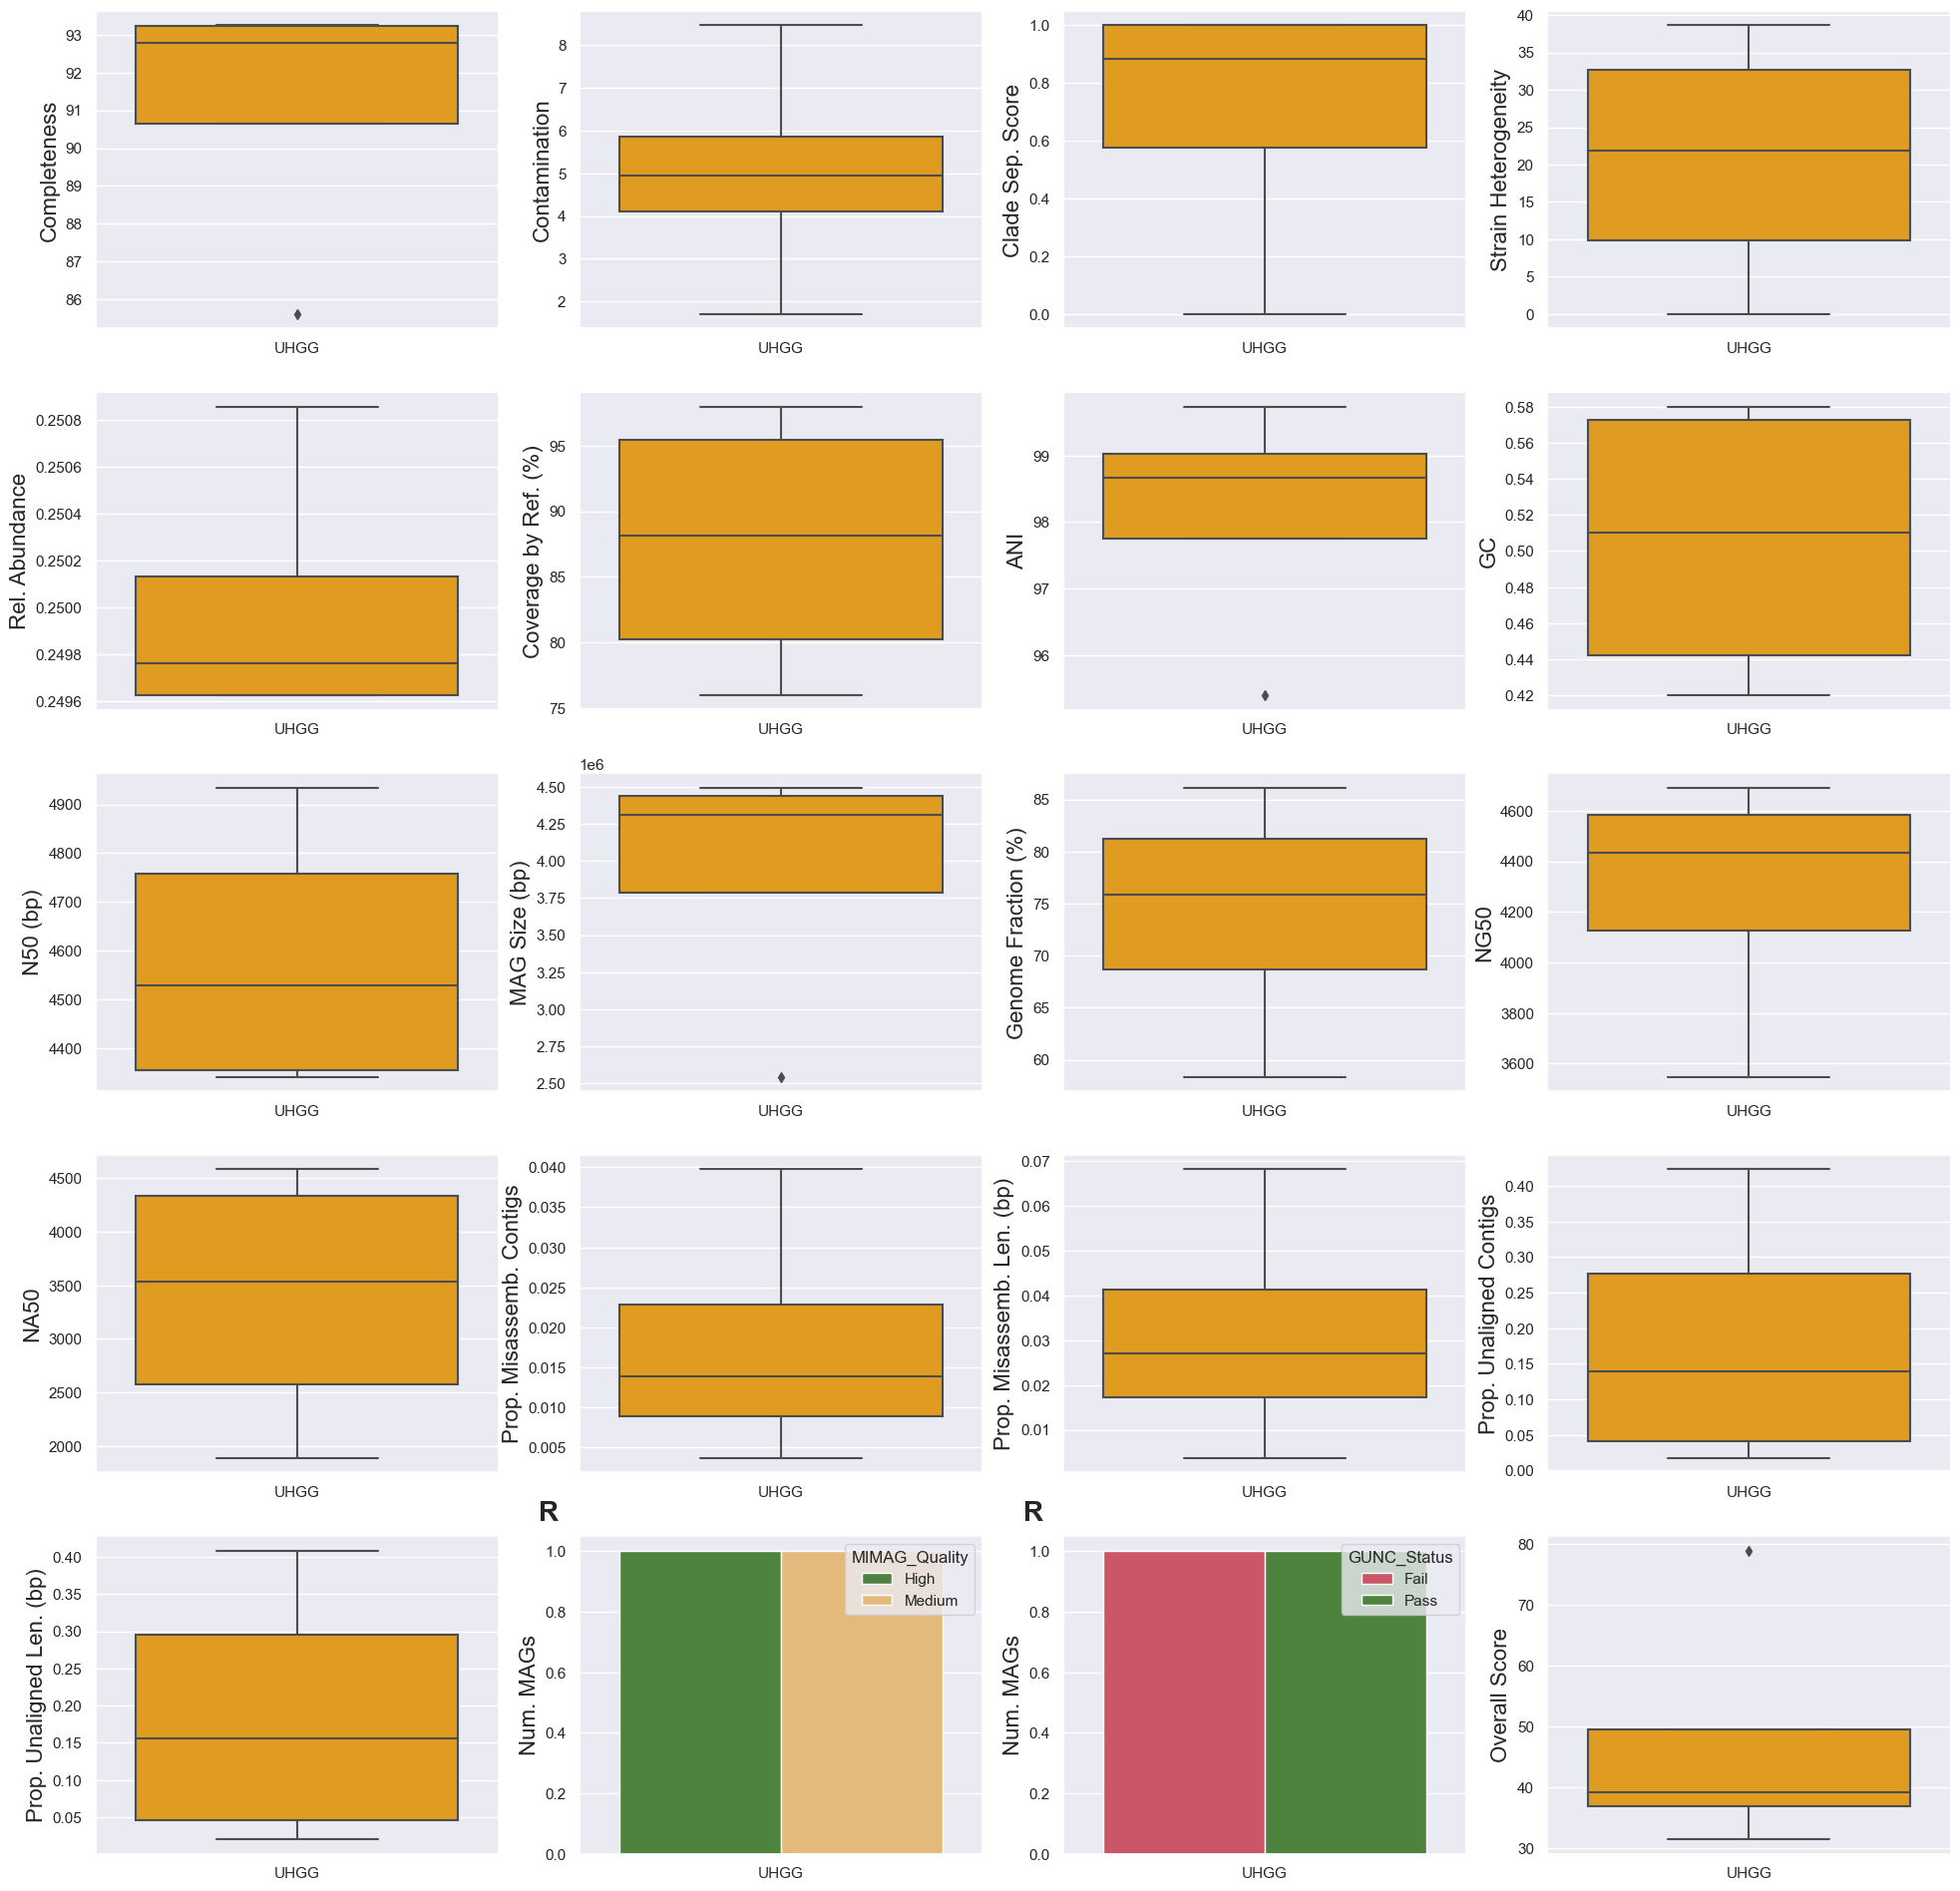

In [42]:
fig, axs = plt.subplots(num_rows, num_cols, figsize = (24,24)) # in.
for j, p in enumerate(parameters): # for i, df in enumerate(stats_df_lst):
    row = int(j // num_cols)
    col = int(j % num_cols)
    box_plot(stats_df, p, param_names[j], axs[row,col])

    
# MIMAG quality counts
qual_df = stats_df.groupby(['sample_name', 'MIMAG_Quality']).count().reset_index()
p = sns.countplot(data = qual_df, x = 'sample_name', hue = 'MIMAG_Quality', 
        palette = ['#488f31', '#f4bd6a','#de425b'], ax = axs[4,1]) # 'Draft' ('#356924' ,), 'High', 'Medium', 'Low'
p.set_xticklabels(samples_labeled)
p.set_xlabel(None)
p.set_ylabel('Num. MAGs', size = 16) # Set the y-axis label as the parameter only 
axs[4,1].text(-0.1, 1.05, string.ascii_uppercase[j+1], transform=axs[4,1].transAxes, size=20, fontweight = 'bold') 

# GUNC Pass/Fail counts
qual_df = stats_df.groupby(['sample_name', 'GUNC_Status']).count().reset_index()
p = sns.countplot(data = qual_df, x = 'sample_name', hue = 'GUNC_Status', 
        palette = ['#de425b', '#488f31'], ax = axs[4,2]) # 'Fail', 'Pass'
p.set_xticklabels(samples_labeled)
p.set_xlabel(None)
p.set_ylabel('Num. MAGs', size = 16) # Set the y-axis label as the parameter only 
axs[4,2].text(-0.1, 1.05, string.ascii_uppercase[j+1], transform=axs[4,2].transAxes, size=20, fontweight = 'bold') 

# Overall dRep-based quality scores
box_plot(stats_df, 'Overall_Score', 'Overall Score', axs[4,3]) 

In [56]:
fig.savefig(join(out_dir, 'summary_statistics.png'), dpi = 1000, bbox_inches = 'tight')

## Reference Genome-based Comparisons

### Uniquely Classified MAGs

In [57]:
# For each sample, report total number of MAGs, total number of classified MAGs, total 
# number of species-classified MAGs
classification_stats_lst = []

for i,df in enumerate(stats_df_lst):
    stats_tmp = [samples_ordered[i], df.shape[0]]
    stats_tmp.append(df[pd.notna(df['classification'])].shape[0])
    stats_tmp.append(df['species'].str.strip().ne('').sum()) # Specifically counts non-empty strings
    num_unique = len(set(df[df['species'].str.strip().ne('')]['species']))
    stats_tmp.append(num_unique) 
    classification_stats_lst.append(stats_tmp)
    
class_stats_df = pd.DataFrame(classification_stats_lst, columns = ['sample_name', 'num_mags', 'num_classified', 
                                                                   'num_species', 'num_unique_species'])
class_stats_df

,sample_name,num_mags,num_classified,num_species,num_unique_species
0,uhgg,4,4,4,4


In [58]:
# Filter each of the dataframes down to only the MAGs that were classified at the species level
species_only_lst = []
for df in stats_df_lst:
    species_only_lst.append(df[df['species'].str.strip().ne('')])
    
species_df = pd.concat(species_only_lst)

### Reference-based vs. proxy quality statistics

In [59]:
%%capture
# To suppress figure output
# Define plotting region
# Rows:    3. Row 1 graphs the numbers of reads. Row 2 graphs the number of bases.
# Columns: Number of sample sets. Each graph summarizes the samples from a single CSV.  
# parameters = ['completeness','contamination','bin_cov','ANI','GC',\
#               'N50','size','genome_fraction','NG50','NA50','num_ctgs','prop_misassemb_ctgs',\
#               'prop_misassemb_len','prop_unaln_ctgs','prop_unaln_len'] 
axes_params = {'completeness'     : 'genome_fraction', 
               'contamination'    : 'prop_unaln_len', 
               'clade_separation_score' : 'prop_unaln_len', 
               'strain_het'          : 'prop_unaln_len'}
axes_labels = {'Completeness'     : 'Genome Fraction', 
               'Contamination'    : 'Prop. Unaligned Len.', 
               'Clade Sep. Score' : 'Prop. Unaligned Len.', 
               'Strain Heterogeneity'        : 'Prop. Unaligned Len.'}
axes_labels_keys = list(axes_labels.keys())
fig, axs = plt.subplots(2, 2, figsize = (12,12)) # in.

In [66]:
def dot_plot(df, x_param, y_param, x_label, y_label, a):
    p = sns.regplot(data = df, x = x_param, y = y_param, ax = a)
    p.set_xlabel(x_label, size = 16) 
    p.set_ylabel(y_label, size = 16) 
    # Pearson correlation with SciPy:
    corr = pearsonr(df[x_param], df[y_param])
    corr = [np.round(c, 2) for c in corr]
    text = 'r = %s' % (corr[0])
    axs[row,col].text(0.8, 0.05, text, transform=a.transAxes, size=12)
    print(text)
    return p

In [67]:
for i, c in enumerate(axes_params):
    x_label = axes_labels_keys[i]
    row = int(i // 2)
    col = int(i % 2)
    dot_plot(species_df, c, axes_params[c], x_label, axes_labels[x_label], axs[row,col])
    axs[row,col].text(-0.1, 1.05, string.ascii_uppercase[i], transform=axs[row,col].transAxes, size=20)  
    # TODO adjust position

0    86.106
1    79.650
2    72.111
3    58.361
Name: genome_fraction, dtype: float64
r = -0.31
0    0.055317
1    0.019925
2    0.257660
3    0.408548
Name: prop_unaln_len, dtype: float64
r = 0.51
0    0.055317
1    0.019925
2    0.257660
3    0.408548
Name: prop_unaln_len, dtype: float64
r = 0.65
0    0.055317
1    0.019925
2    0.257660
3    0.408548
Name: prop_unaln_len, dtype: float64
r = 0.29


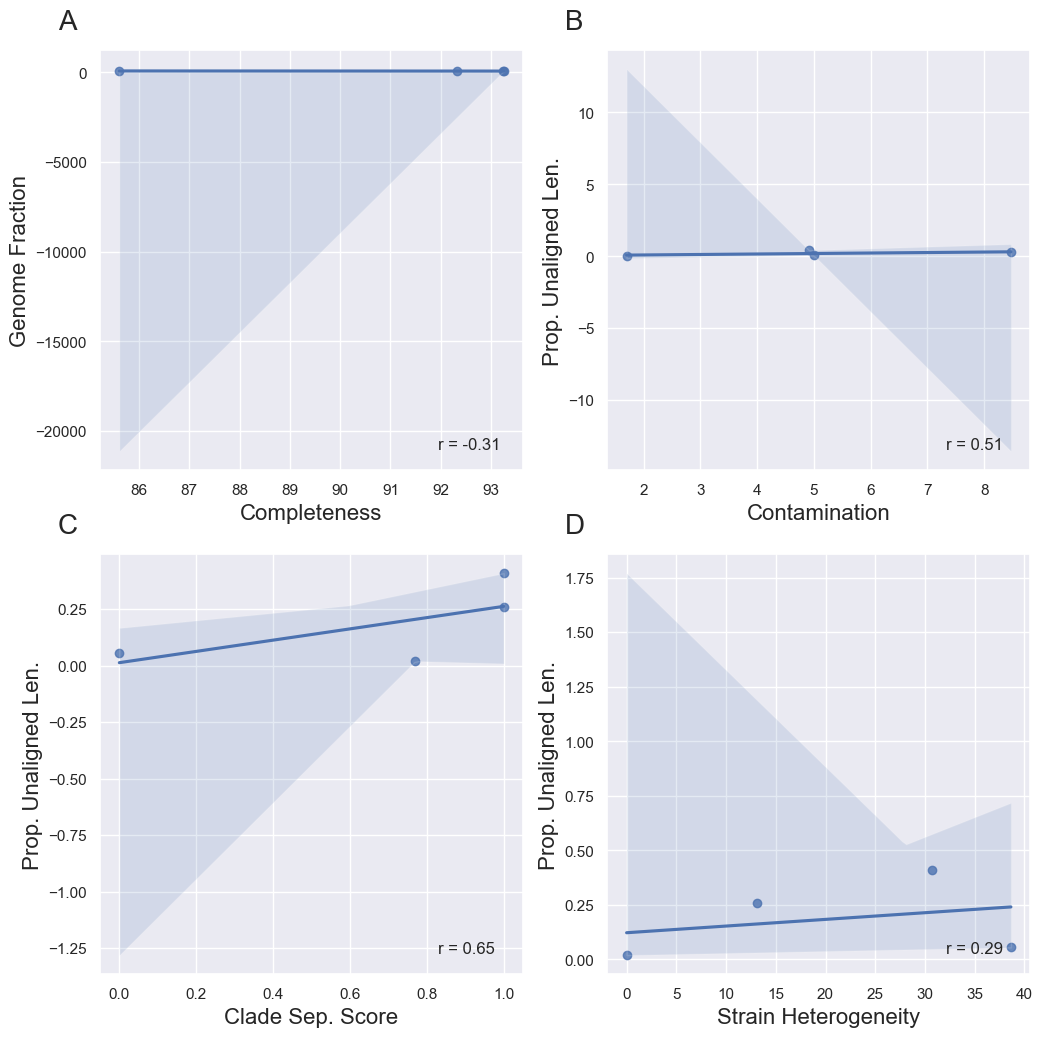

In [62]:
fig

In [68]:
fig.savefig(join(out_dir, 'ref_vs_proxy_stats.png'), dpi = 1000, bbox_inches = 'tight')

### Coverage of MAGs by Classified Reference Genomes and Vice Versa

In [71]:
def coverage_dot_plot(df):
    p = sns.scatterplot(data = df, x = 'bin_cov', y = 'ref_cov', hue = 'sample_name', palette = samples_colours)
    p.set_xlabel('MAG Cov. (%)', size = 16) 
    p.set_ylabel('Reference Cov. (%)', size = 16) 
    p.legend(labels = samples_labeled)
    corr = pearsonr(df['bin_cov'], df['ref_cov'])
    corr = [np.round(c, 2) for c in corr]
    text = 'r = %s' % (corr[0])
    p.text(0.8, 0.05, text, transform=p.transAxes, size=12)
    print(text)
    return p

r = 0.68


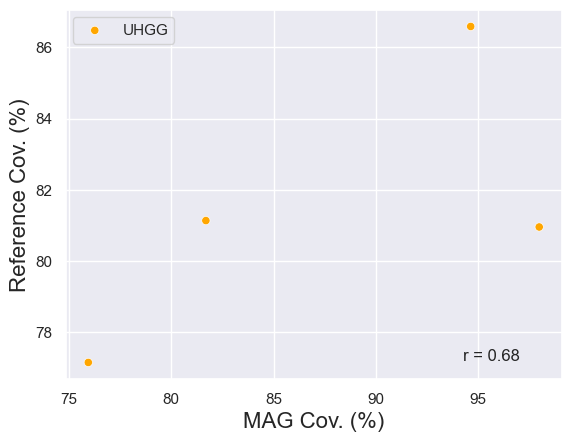

In [72]:
p = coverage_dot_plot(species_df)

In [73]:
p.get_figure().savefig(join(out_dir, 'mag_ref_cov.png'), dpi = 1000, bbox_inches = 'tight')

# Inter-Sample Comparisons

## Alpha Diversity

In [83]:
# Make classified MAG relative abundance dataframes the same way
# Add MAG summary statistics tables for each sample set to a list
# Merge the sample set dataframes and check their contents
ra_df_lst = []
for s in stats_lst:
    tmp_df = pd.read_csv(s, header = 0)
    sample_name = basename(s).split('.')[0]
    tmp_df.insert(0, 'sample_name', [sample_name] * num_mags)
    tmp_df[sample_name] = tmp_df['avg_mag_ra']
    fin_df = tmp_df[['classification', sample_name]]
    ra_df_lst.append(fin_df)

ra_df = ra_df_lst[0]
for i in range(1, len(ra_df_lst)):
    ra_df = pd.merge(ra_df, ra_df_lst[i], on = ['classification'])

# ra_df.iloc[[1,20,40],:] 
ra_df

,classification,uhgg
0,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,0.250856
1,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__O...,0.249627
2,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__L...,0.249893
3,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacill...,0.249624


## Shannon Diversity

In [84]:
# Make a presence-absence dataframe by casting non-zero relative abundances up to 1
pa_df = ra_df.copy()
for s in samples_ordered:
    pa_df[s] = [1 if a > 0 else 0 for a in ra_df[s]]

# pa_df.iloc[[1,20,40],:]
pa_df

,classification,uhgg
0,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,1
1,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__O...,1
2,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__L...,1
3,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacill...,1


In [76]:
# Sum the presence-absences of all taxa for each sample prep and melt the sample columns together for a flatter dataframe
# Can't do this with just one sample so this is for show only
agg_dct = {}
for c in samples_ordered:
    agg_dct[c] = 'sum'

pa_melt_df = pa_df.aggregate(agg_dct)
# pa_melt_df = pd.DataFrame({'sample_name':pa_tmp_df.index, 'Num. Taxa':pa_tmp_df.values})

pa_melt_df

uhgg    4
dtype: int64

In [77]:
def shannon_index(row):
    s_lst = []
    for s in samples_ordered:
        if row[s] == 0:
            s_lst.append(0)
        else:
            s_lst.append(-log(float(row[s]))*float(row[s]))
    return s_lst

In [78]:
# Calculate H for each sample
tmp_lst = list(ra_df.apply(lambda row : shannon_index(row), axis = 1))
h_df = pd.DataFrame(tmp_lst, columns = samples_ordered)
print('{}'.format(h_df.shape))

# h_df.iloc[[1,20,40],:]
h_df

(4, 1)


,uhgg
0,0.353582
1,0.356366
2,0.331445
3,0.339518


In [79]:
# Sum H for each sample prep and melt the sample prep columns together
# Can't do this with just one sample so this is for show only
h_melt_df = h_df.aggregate(agg_dct)
# h_melt_df = pd.DataFrame({'sample_name':h_tmp_df.index, 'Shannon Index':h_tmp_df.values})

h_melt_df

uhgg    1.380911
dtype: float64

In [80]:
def bar_plot(df, a, stat):
    # stat = pres_abs or shannon
    p = sns.barplot(data = df, x = 'sample_name', y = stat, palette = samples_colours, ax = a)
    p.set_xticklabels(samples_labeled, size = 16) #, rotation = 45, ha = 'right') # Relabel each of the groups
    p.set(xlabel = None, ylabel = stat) 
    return p

In [81]:
%%capture
# To suppress figure output
# Define plotting region (1 row, 2 columns 1 for each diversity metric)
num_rows = 1
num_cols = 2
fig, axs = plt.subplots(num_rows, num_cols, figsize = (24,12)) # in.
alpha_stat = ['Num. Taxa', 'Shannon Index']

In [34]:
# Plot the number of taxa and Shannon entropy from each sample prep
# Can't do this with just one sample so this is for show only
# for i, df in enumerate([pa_melt_df, h_melt_df]):
#      bar_plot(df, axs[i], alpha_stat[i])

In [35]:
# fig.savefig(join(out_dir, 'num_shanh.svg'), dpi = 1000, bbox_inches = 'tight')

## Species Sharing

In [82]:
def cluster_map(df, r):
    p = sns.clustermap(df, cmap = 'rocket', figsize = (6,6))
    p.ax_heatmap.set_xlabel(r.capitalize())
    # Adjust x,y position (0,0 is lower left)  and size of colour-bar legend
    p.ax_cbar.set_position((0.08,0.83,0.03,0.13)) 
    return p

### Jaccard Difference Cluster Plots

In [ ]:
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import pairwise_distances

# Calculate the Jaccard difference from the relative abundance dataframe 
tmp_df = pa_df.drop(['species'], axis = 1)
transposed_df = tmp_df.transpose()
jcd_df = pd.DataFrame(squareform(pdist(transposed_df, 'jaccard')), index = transposed_df.index, columns = transposed_df.index)

jcd_df

In [ ]:
cluster_map(jcd_df, 'species')

In [ ]:
# Calculate the Euclidean difference from the relative abundance dataframe 
tmp_df = ra_df.drop(['species'], axis = 1)
transposed_df = tmp_df.transpose()
transposed_df.fillna(0, inplace = True)
euc_df = pd.DataFrame(squareform(pdist(transposed_df, 'euclidean')), index = transposed_df.index, columns = transposed_df.index)

euc_df

In [ ]:
cluster_map(euc_df, 'species')

### Upset Plots

In [ ]:
from upsetplot import from_contents, UpSet

def make_upset_df(raw_df):
    combo_names = list(raw_df.index)
    cmb_dct = raw_df.to_dict(orient = 'list')
    new_dct = {}
    for k,v in cmb_dct.items():
        new_dct[k] = []
        for j,pa in enumerate(v):
            if pa == 1:
                new_dct[k].append(combo_names[j])
    return new_dct

In [ ]:
# Set the species as the dataframe index
pa_idx_df = pa_df.copy()
pa_idx_df.set_index('species', inplace=True)
pa_idx_df = pa_idx_df.transpose()
pa_idx_df.head()

In [ ]:
# Convert the presence-absence dataframes into upset plot-compatible dataframes 
# Here, I've divided the species up by the number of samples the species appeared in
species_dct_lst = []
num_samples = pa_idx_df.shape[0]
for i in range(1,num_samples + 1):
    tmp_df = pa_idx_df.loc[:,(pa_idx_df.sum(axis = 0) == i)]
    species_dct = make_upset_df(tmp_df)
    print('In {} samples: {} species: {}'.format(i, len(species_dct.keys()), list(species_dct.keys())))
    if species_dct:
        species_dct_lst.append(from_contents(species_dct))

species_dct_lst[-1]

In [ ]:
# Make an upset plot for all species
tmp_df = pa_idx_df.loc[:,(pa_idx_df.sum(axis = 0) > num_samples // 2)]
species_dct = make_upset_df(tmp_df)
species_df = from_contents(species_dct)
# print('In a majority of samples: {} phyla: {}'.format(len(phylum_cmb_dct.keys()), list(phylum_cmb_dct.keys())))
UpSet(species_df, show_counts = True)

### Common Species Quality Comparison

In [ ]:
# Extract only the common species found in the sample combinations
common_species = list(species_dct_lst[-1].index.names)
common_species_lst = []
for df in stats_df_lst:
    raw_df = df[df['species'].isin(common_species)]
    tmp_df = raw_df[['species', 'size', 'completeness', 'contamination', 'clade_separation_score']]
    print(tmp_df.shape)
    common_species_lst.append(tmp_df)